In [1]:
!git clone https://bitbucket.org/agiaz/sigmml.git

Cloning into 'sigmml'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 24 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (24/24), 316.38 MiB | 9.04 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (17/17), done.


In [2]:
!pip install git+https://bitbucket.org/agiaz/research.git@0.9
!pip install git+https://bitbucket.org/agiaz/datasets.git@0.5

  Cloning https://bitbucket.org/agiaz/research.git (to revision 0.9) to /tmp/pip-req-build-q4tnre_w
  Running command git clone --filter=blob:none --quiet https://bitbucket.org/agiaz/research.git /tmp/pip-req-build-q4tnre_w
  Running command git checkout -b 0.9 --track origin/0.9
  Switched to a new branch '0.9'
  Branch '0.9' set up to track remote branch '0.9' from 'origin'.
  Resolved https://bitbucket.org/agiaz/research.git to commit 56d2affee01357af828c1c0df449a43fae7c1e67
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for research: filename=research-0.9.0-py3-none-any.whl size=37396 sha256=323cd6dc1b05a008d8739f521e6b9f4b0118c70ff708ac8a60a91e2c28f2890d
  Stored in directory: /tmp/pip-ephem-wheel-cache-bfuvxxpl/wheels/b2/e7/6e/b321f4d51da4ed4d7ef4ffeaa55d4864319c1719281aea91ea
Successfully built research
  Cloning https://bitbucket.org/agiaz/datasets.git (to revision 0.5) to /t

In [3]:
cd sigmml

/kaggle/working/sigmml


In [4]:
%%writefile config.py
import argparse
import random as rnd


def get_settings() -> argparse.Namespace:
    parser = argparse.ArgumentParser()
    parser.add_argument("--data-batch-size", type=int, default=512)
    parser.add_argument("--lstm-layers", type=int, default=2)
    parser.add_argument("--save-optimizer", type=bool, default=False)
    parser.add_argument("--save-freq", type=int, default=2000)
    parser.add_argument(
        "--save-path",
        type=str,
        default="./snapshot/similarity learning/{0} dim/{1}"
    )
    parser.add_argument("--decay-freq", type=int, default=5000)
    parser.add_argument("--decay-rate", type=float, default=0.5)
    parser.add_argument("--max-exp-mem", type=int, default=None)
    parser.add_argument("--observation-epochs", type=int, default=600)
    parser.add_argument("--learning-epochs", type=int, default=200)
    parser.add_argument("--max-train-steps", type=int, default=205)
    parser.add_argument("--train-steps", type=int, default=5)
    parser.add_argument("--optimizer-lr", type=float, default=0.001)
    parser.add_argument("--rgd-lr", type=float, default=0.01)
    parser.add_argument("--log-to-file", type=bool, default=True)
    parser.add_argument("--spd-batch-size", type=int, default=12)
    parser.add_argument(
        "--data-path",
        type=str,
        default="/kaggle/working/sigmml/data/{0}_10x10covs_SPD_DP_10_5no_nof_seg_1.npy",
        # comment the above line and uncomment the below one
        # for the overlapping window
        # default="./data/{0}_10x10covs_SPD_DP_10_7_5o_nof_seg_1.npy",
    )
    parser.add_argument("--dim", type=int, default=3)
    # comment the above line and uncomment the below one
    # for the overlapping window
    # parser.add_argument("--dim", type=int, default=11)
    parser.add_argument("--num-of-writers", type=int, default=55)
    parser.add_argument("--num-of-gen-samples", type=int, default=24)
    parser.add_argument("--num-of-forg-samples", type=int, default=24)
    parser.add_argument("--do-gg-prod", type=bool, default=False)
    parser.add_argument("--learning-perc", type=float, default=0.5)
    parser.add_argument("--training-perc", type=float, default=0.7)
    # parser.add_argument("--random-forg-perc", type=float, default=0)
    parser.add_argument("--random-forg-perc", type=float, default=0.5)
    # parser.add_argument("--random-forg-perc", type=float, default=1)
    parser.add_argument("--amount-of-testing-gens", type=int, default=10)
    parser.add_argument("--zeta-sim", type=int, default=0.01)
    parser.add_argument("--zeta-disim", type=int, default=1)
    parser.add_argument("--reset-with-call", type=bool, default=False)
    parser.add_argument("--learner-epochs", type=int, default=50)
    parser.add_argument("--total-iterations", type=int, default=10)
    parser.add_argument("--convergence-cycles", type=int, default=5)
    parser.add_argument("--auc-threshold", type=float, default=0.99)
    parser.add_argument("--testing-iterations", type=int, default=10)
    # RNG Seed
    parser.add_argument("--seed", type=int, default=rnd.randrange(2**32 - 1))
    return parser.parse_known_args()[0]

Overwriting config.py


In [5]:
%%writefile impls.py
import argparse
import sys
from typing import Dict, List, Optional, Tuple, Union

import numpy as np
import torch
from datasets.images.signatures import SignaturePairFeatures
from research.metrics import contrastive_loss
from research.nn.init import random_spd_
from research.nn.spd.optim import LSTMddSPDOptimizer
from sklearn.metrics import auc, roc_curve
from torch.utils import data


def similarity_learning(
    inputs: torch.Tensor,
    spd_param: torch.Tensor,
    labels: torch.Tensor,
    opts: argparse.Namespace,
) -> torch.Tensor:
    total_dists = torch.zeros(inputs.shape[0], device=inputs.device)
    for idx in range(spd_param.shape[0]):
        total_dists += torch.sqrt(
            inputs @ spd_param[idx] @ inputs.mT + 1e-8
        ).squeeze()
    total_dists /= spd_param.shape[0]
    loss = contrastive_loss(total_dists, labels, opts)
    return loss


class SimilarityLearner:
    def __init__(self, opts: argparse.Namespace) -> None:
        self.spd_param = torch.empty(
            (opts.spd_batch_size, opts.dim, opts.dim),
            device=opts.device,
            requires_grad=True,
        )
        random_spd_(self.spd_param)
        self.opts = opts

    def __call__(self, inputs: torch.Tensor) -> torch.Tensor:
        dists = torch.zeros(inputs.shape[0], device=inputs.device)
        for idx in range(self.spd_param.shape[0]):
            dists += torch.sqrt(
                inputs @ self.spd_param[idx] @ inputs.mT + 1e-8
            ).squeeze()
        dists /= self.spd_param.shape[0]
        return dists

    def loss(self, inputs: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        distances = self(inputs)
        return contrastive_loss(distances, labels, self.opts)

    def reset(self) -> None:
        self.spd_param = torch.empty_like(self.spd_param)
        random_spd_(self.spd_param)


def training(
    learner: SimilarityLearner,
    loader: data.DataLoader,
    dd_optimizer: LSTMddSPDOptimizer,
    opts: argparse.Namespace,
    states: Optional[Tuple[torch.Tensor, ...]] = None,
) -> Tuple[torch.Tensor, ...]:
    for epoch in range(1, opts.learner_epochs + 1):
        print(f"# region Learner Epoch {epoch:>4}:", file=opts.log_file)
        for batch, (inputs, labels) in enumerate(loader):
            inputs, labels = inputs.to(opts.device), labels.to(opts.device)
            loss = learner.loss(inputs, labels)
            print(
                f"\tBatch {batch:>5} loss := {loss.item():>10.4f}",
                file=opts.log_file,
            )
            loss.backward()
            with torch.no_grad():
                _, learner.spd_param, states = dd_optimizer(
                    learner.spd_param, states
                )
            learner.spd_param = learner.spd_param.detach()
            learner.spd_param.requires_grad = True
        print("# endregion\n", file=opts.log_file)
    return states


def validation(
    learner: SimilarityLearner,
    loader: data.DataLoader,
    opts: argparse.Namespace,
) -> float:
    all_distances = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in iter(loader):
            inputs = inputs.to(opts.device)
            distances = learner(inputs)
            all_distances.append(distances.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    distances = np.concatenate(all_distances)
    labels = np.concatenate(all_labels)
    # return roc_auc_score(labels, distances)
    # pos_label=0 because low scores == pos_label, but calculations invert it
    fpr, tpr, thresh = roc_curve(labels, distances, pos_label=0)
    score = auc(fpr, tpr)
    print(f"Validation AUC score: {score:>10.4f}\n\n", file=opts.log_file)
    return fpr, tpr, score, thresh


def testing(
    learner: SimilarityLearner,
    dataset: SignaturePairFeatures,
    opts: argparse.Namespace,
) -> Tuple[torch.Tensor, torch.Tensor]:
    dataset.test()

    questioned_samples = (
        opts.num_of_gen_samples
        - opts.amount_of_testing_gens
        + opts.num_of_forg_samples
    )
    result_dists = torch.empty(
        (len(dataset), opts.testing_iterations, 3, questioned_samples),
        device=opts.device,
    )

    with torch.no_grad():
        for itr in range(opts.testing_iterations):
            # all labels are the same since they will not be shuffled
            for writer_idx, (combs, labels) in enumerate(dataset):
                combs = combs.to(opts.device)

                writer_output = torch.empty(
                    size=(combs.shape[0], combs.shape[1])
                )
                for idx in range(combs.shape[0]):
                    scores = learner(combs[idx])
                    writer_output[idx] = scores

                result_dists[writer_idx, itr, 0] = writer_output.min(dim=0)[0]
                result_dists[writer_idx, itr, 1] = writer_output.mean(dim=0)
                result_dists[writer_idx, itr, 2] = writer_output.max(dim=0)[0]
    return result_dists, labels


def testing_metric(
    test_dists: np.ndarray, labels: np.ndarray
) -> List[List[Dict[str, Dict[str, Union[np.ndarray, float]]]]]:
    # roc[writer][itr]["min/mean/max"]["fpr/tpr/eer_error"]
    roc = []
    for writer_idx in range(test_dists.shape[0]):
        writer = []
        for itr_idx in range(test_dists.shape[1]):
            itr = {"min": {}, "mean": {}, "max": {}}

            itr["min"]["fpr"], itr["min"]["tpr"], _ = roc_curve(
                labels, test_dists[writer_idx, itr_idx, 0], pos_label=0
            )
            itr["min"]["eer_error"] = np.min(
                np.mean(
                    np.row_stack((1 - itr["min"]["tpr"], itr["min"]["fpr"])),
                    axis=0,
                )
            )

            itr["mean"]["fpr"], itr["mean"]["tpr"], _ = roc_curve(
                labels, test_dists[writer_idx, itr_idx, 1], pos_label=0
            )
            itr["mean"]["eer_error"] = np.min(
                np.mean(
                    np.row_stack((1 - itr["mean"]["tpr"], itr["mean"]["fpr"])),
                    axis=0,
                )
            )

            itr["max"]["fpr"], itr["max"]["tpr"], _ = roc_curve(
                labels, test_dists[writer_idx, itr_idx, 2], pos_label=0
            )
            itr["max"]["eer_error"] = np.min(
                np.mean(
                    np.row_stack((1 - itr["max"]["tpr"], itr["max"]["fpr"])),
                    axis=0,
                )
            )

            writer.append(itr)
        roc.append(writer)
    return roc



Overwriting impls.py


In [6]:
%%writefile train.py
import argparse
import os
import random as rnd
import sys
from pathlib import Path

import numpy as np
import torch
from config import get_settings
from datasets.images.signatures import SignaturePairFeatures
from impls import SimilarityLearner, similarity_learning, training, validation
from research.nn.spd.optim import (
    LSTMddSPDOptimizer,
    _learning_stage,
    _observation_stage,
    eigen_decomp,
)
from research.optim.spd import ProjectionRetractionRGD
from torch.utils import data


def train_model(
    dataset: SignaturePairFeatures, opts: argparse.Namespace
) -> None:
    if sys.platform == "win32":
        loader = data.DataLoader(
            dataset, batch_size=opts.data_batch_size, shuffle=True
        )
    else:
        loader = data.DataLoader(
            dataset,
            batch_size=opts.data_batch_size,
            shuffle=True,
            num_workers=4,
            persistent_workers=True,
            pin_memory=True,
        )

    riem_optimizer = ProjectionRetractionRGD(
        learning_rate=opts.rgd_lr, eigen_decomp=eigen_decomp
    ).to(opts.device)
    replay_buffer_list = _observation_stage(
        similarity_learning, riem_optimizer, loader, opts
    )
    dd_optimizer = LSTMddSPDOptimizer(
        opts.dim, opts.lstm_layers, opts.spd_batch_size
    ).to(opts.device)
    global_optimizer = torch.optim.Adamax(
        dd_optimizer.parameters(), opts.optimizer_lr
    )
    learner = SimilarityLearner(opts)

    states = None
    num_of_no_auc_changes = 0
    best_auc = 0
    best_param = learner.spd_param.detach()
    col_fpr = None
    col_tpr = None
    for itr in range(1, opts.total_iterations + 1):
        print("█" * 120, file=opts.log_file)
        print(f"Learning iteration {itr:>3}:", file=opts.log_file)
        dataset.train()
        dd_optimizer.train()
        _learning_stage(
            replay_buffer_list,
            similarity_learning,
            dd_optimizer,
            global_optimizer,
            loader,
            opts,
        )
        dd_optimizer.eval()
        states = training(learner, loader, dd_optimizer, opts, states)

        dataset.eval()
        if sys.platform == "win32":
            val_loader = data.DataLoader(
                dataset, batch_size=opts.data_batch_size, shuffle=True
            )
        else:
            val_loader = data.DataLoader(
                dataset,
                batch_size=opts.data_batch_size,
                shuffle=True,
                num_workers=4,
                persistent_workers=True,
                pin_memory=True,
            )
        fpr, tpr, auc, thresh = validation(learner, val_loader, opts)
        np.save(f"{opts.save_path}/fpr_{itr}.npy", fpr)
        np.save(f"{opts.save_path}/tpr_{itr}.npy", tpr)
        np.save(f"{opts.save_path}/thresh_{itr}.npy", thresh)
        del val_loader

        if abs(auc - best_auc) <= 1e-6:
            num_of_no_auc_changes += 1
            if num_of_no_auc_changes == opts.convergence_cycles:
                print(
                    "Validation metric converged in learning iteration"
                    f" {itr:>3}, with total training epochs"
                    f" {itr * opts.learner_epochs:>10}.",
                    file=opts.log_file,
                )
                break
        else:
            num_of_no_auc_changes = 0

        if auc > best_auc:
            best_auc = auc
            best_param = learner.spd_param.detach()

        if best_auc >= opts.auc_threshold:
            print(
                "Validation metric exceeded set threshold in learning iteration"
                f" {itr:>3} with total training epochs"
                f" {itr * opts.learner_epochs:>10}.",
                file=opts.log_file,
            )
            break
        print("█" * 120, file=opts.log_file)
    torch.save(best_param, opts.save_path + "/model.pt")

if __name__ == "__main__":
    os.chdir("../")
    opts = get_settings()
    if opts.max_exp_mem is None:
        opts.max_exp_mem = opts.observation_epochs
    opts.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    opts.training_perc = 0.9

    rnd.seed(opts.seed)
    np.random.seed(opts.seed)
    torch.manual_seed(opts.seed)

    datasets = [
        ("BENGALI", 100, 24, 30),
        ("CEDAR", 55, 24, 24),
    ]
    data_path = opts.data_path
    save_path = opts.save_path
    for dataset in datasets:
        opts.dataset = dataset[0]
        opts.data_path = data_path.format(dataset[0])
        opts.save_path = save_path.format(opts.dim, dataset[0])
        opts.num_of_writers = dataset[1]
        opts.num_of_gen_samples = dataset[2]
        opts.num_of_forg_samples = dataset[3]
        # opts.learning_perc = 0.9
        Path(opts.save_path).absolute().mkdir(parents=True, exist_ok=True)
        with open(opts.save_path + "/train.log", "w", encoding="utf-8") as f:
            opts.log_file = f
            ds = SignaturePairFeatures(opts)
            train_model(ds, opts)
        # train_model(SignaturePairFeatures(opts), opts)

Overwriting train.py


In [7]:
!ls data

BENGALI_10x10covs_SPD_DP_10_5no_nof_seg_1.npy
BENGALI_10x10covs_SPD_DP_10_7_5o_nof_seg_1.npy
CEDAR_10x10covs_SPD_DP_10_5no_nof_seg_1.npy
CEDAR_10x10covs_SPD_DP_10_7_5o_nof_seg_1.npy


In [8]:
!python train.py

In [15]:
%%writefile inter_test.py
#!/usr/bin/python
import os
import pickle as pc

import impls
import torch
from config import get_settings
from datasets.images import signatures as sigs

if __name__ == "__main__":
    os.chdir("../")
    opts = get_settings()
    data_path = opts.data_path
    opts.learning_perc = 0
    opts.training_perc = 0
    opts.amount_of_testing_gens = 10
    opts.do_gg_prod = False
    opts.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    datasets = [
        ("BENGALI", 100, 24, 30),
        ("CEDAR", 55, 24, 24),
    ]
    learner = impls.SimilarityLearner(opts)
    results = {}
    for idx in range(len(datasets)):
        save_path = f"./snapshot/similarity learning/{opts.dim} dim"
        data = datasets.pop(idx)
        opts.save_path = save_path.format(opts.dim) + f"/{data[0]}"
        learner.spd_param = torch.load(
            opts.save_path + "/model.pt"
        ).to(opts.device)
        results[data[0]] = [(data[0], "-")]
        for dataset in datasets:
            opts.num_of_writers = dataset[1]
            opts.num_of_gen_samples = dataset[2]
            opts.num_of_forg_samples = dataset[3]
            opts.data_path = data_path.format(dataset[0])
            ds = sigs.SignaturePairFeatures(opts)
            dists, labels = impls.testing(learner, ds, opts)
            result = impls.testing_metric(
                dists.cpu().numpy(), labels.cpu().numpy()
            )
            # dataset_name, fpr, tpr, eer_error
            results[data[0]].append((dataset[0], result))
        datasets.insert(idx, data)
    with open(save_path + "/inter_testing.pickle", "wb") as f:
        pc.dump(results, f)

Overwriting inter_test.py


In [16]:
!python inter_test.py

/kaggle/working/sigmml/inter_test.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  learner.spd_param = torch.load(
/kaggle/working/sigmml/inter_test.py:29: FutureWarning

In [25]:
cd /kaggle/working/snapshot/similarity learning/3 dim

/kaggle/working/snapshot/similarity learning/3 dim


In [34]:
import numpy as np
from sklearn.metrics import roc_curve
import sklearn
import matplotlib.pyplot as plt
def get(fpr, tpr, thresholds):
    # Tính FNR (False Negative Rate)
    fnr = 1 - tpr  # FNR = 1 - TPR

    # Tính khoảng cách giữa FPR và FNR
    abs_diff = np.abs(fpr - fnr)

    # Tìm chỉ số có giá trị nhỏ nhất (EER)
    eer_index = np.argmin(abs_diff)
    eer = fpr[eer_index]  # EER là FPR tại ngưỡng đó
    threshold_at_eer = thresholds[eer_index]

    # Hiển thị kết quả
    print(f"EER: {eer:.4f}")
    print(f"Threshold at EER: {threshold_at_eer:.4f}")

    # Vẽ ROC curve
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    display = sklearn.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Estimator')
    display.plot()
    plt.show()

EER: 0.0714
Threshold at EER: 1.5250


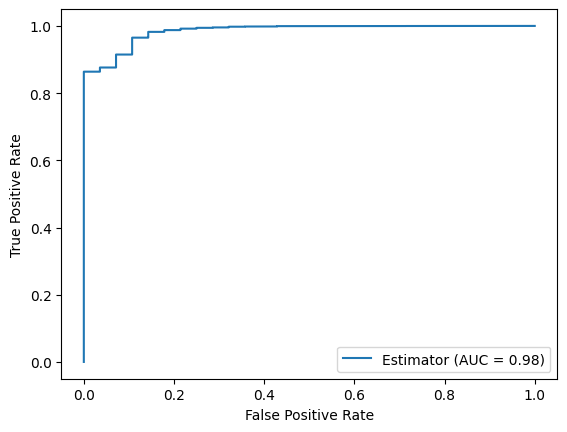

In [35]:
EER_cedar = get(np.load('CEDAR/fpr_10.npy'), np.load('CEDAR/tpr_10.npy'), np.load('CEDAR/thresh_10.npy'))

EER: 0.1200
Threshold at EER: 1.0277


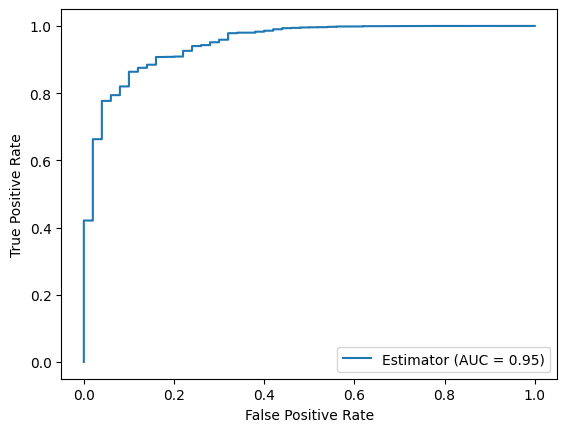

In [36]:
EER_bengali = get(np.load('BENGALI/fpr_10.npy'), np.load('BENGALI/tpr_10.npy'), np.load('BENGALI/thresh_10.npy'))